In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.optimize import curve_fit
import statsmodels.api as sm
import time

# Import permutation weighting package
from permutation_weighting import PW

# Set random seed for reproducibility
np.random.seed(42)

def create_kang_schafer_continuous_dgp(n, misspecified=False, extraneous_covs=0, trt_noise_sd=1, use_logit=True):
    """
    Create a data generating process based on the Kang-Schafer simulation with continuous treatment.
    
    Parameters:
    -----------
    n : int
        Sample size
    misspecified : bool, default=False
        Whether to apply non-linear transformations to covariates
    extraneous_covs : int, default=0
        Number of additional covariates to include
    trt_noise_sd : float, default=1
        Standard deviation of treatment noise
    use_logit : bool, default=True
        Whether to apply logistic transformation to treatment effect
        
    Returns:
    --------
    dict: Dictionary containing treatment, outcome, covariates, and expected values
    """
    # Generate covariance matrix and means for covariates
    sigma = np.eye(4 + extraneous_covs)
    mus = np.zeros(4 + extraneous_covs)
    
    # Generate covariates
    X = np.random.multivariate_normal(mus, sigma, size=n)
    
    # Create treatment assignment
    coef = np.zeros(4 + extraneous_covs)
    # Apply transformation for treatment effect if specified
    #trt_fn = lambda z: 1 / (1 + np.exp(-z)) if use_logit else lambda z: z
    trt_fn = lambda z: np.log(np.clip(z/(1-z), 1e-10, 1e10)) if logit else z  # Clip for stabil
    

    coef[:4] = [1, -0.5, 0.25, 0.1]  # Coefficients for treatment model
    z_score = X @ coef  # Linear predictor for treatment
    
    # Generate outcomes
    outcome = 210 + 27.4*X[:, 0] + 13.7*X[:, 1] + 13.7*X[:, 2] + 13.7*X[:, 3]
    outcome_noise = np.random.normal(size=n)
    
 sigma = diag(4 + extraneous_covs)
  mus = rep(0, 4 + extraneous_covs)
  X <- mvrnorm(n, mu=mus, Sigma=sigma)
  co = rep(0, 4 + extraneous_covs)
  trt_fn = ifelse(logit, function(z) 1 / (1 + exp(z)), function(z) z)
  co[1:4] = c(1, -.5, 0.25, 0.1)
  z_score = X[,1] - 0.5 * X[,2] + 0.25*X[,3] + 0.1 * X[,4]
  z_score = drop(co %*% t(X))
  Outcome <- 210 + 27.4*X[,1] + 13.7*X[,2] + 13.7*X[,3] + 13.7*X[,4]

  outcome_noise = rnorm(n)
    
    # Generate treatment
    dose = z_score + np.random.normal(0, trt_noise_sd, size=n)
    
  


    # Generate outcome with treatment effect
    y = outcome + trt_fn(dose) + outcome_noise
    
    # Apply transformation to covariates if misspecified
    if misspecified:
        X_transformed = np.column_stack([
            np.exp(X[:, 0] / 2),
            X[:, 1] / (1 + np.exp(X[:, 0])) + 10,
            (X[:, 0] * X[:, 2] / 25 + 0.6) ** 3,
            (X[:, 1] + X[:, 3] + 20) ** 2
        ])
        
        if extraneous_covs > 0:
            X_transformed = np.column_stack([X_transformed, X[:, 4:]])
        
        X_df = pd.DataFrame(X_transformed, columns=[f'X{i+1}' for i in range(X_transformed.shape[1])])
    else:
        X_df = pd.DataFrame(X, columns=[f'X{i+1}' for i in range(X.shape[1])])
    
    # Create true function for calculating values at different dose points
    def true_response_function(a):
        return outcome + trt_fn(a)
    
    # Generate test points for evaluation
    Ez_score = np.sum(mus * coef)
    Vz_score = coef @ sigma @ coef
    test_points = np.linspace(-3, 3, 100) * np.sqrt(Vz_score + trt_noise_sd) + Ez_score
    
    return {
        'A': dose,  # Treatment
        'Y': y,     # Outcome
        'X': X_df,  # Covariates
        'test_points': test_points,  # Points for evaluating dose-response
        'true_response_function': true_response_function,  # True dose-response function
        'raw_X': X,  # True covariates (before transformation)
        'trt_fn': trt_fn  # Treatment effect function
    }

def perform_continuous_simulation(dgp_data, methods, num_test_points=100):
    """
    Perform a simulation comparing different weighting methods for estimating
    the dose-response function.
    
    Parameters:
    -----------
    dgp_data : dict
        Data generating process output
    methods : dict
        Dictionary of methods to evaluate
    num_test_points : int, default=100
        Number of test points for evaluating the dose-response function
        
    Returns:
    --------
    dict: Results including estimated dose-response functions and evaluation metrics
    """
    A = dgp_data['A']
    Y = dgp_data['Y']
    X = dgp_data['X'].values
    test_points = dgp_data['test_points']
    true_fn = dgp_data['true_response_function']
    
    # Calculate true values at test points
    n = len(A)
    true_values = np.array([np.mean(true_fn(np.full(n, a))) for a in test_points])
    
    # Store results
    results = {
        'test_points': test_points,
        'true_values': true_values,
        'estimates': {},
        'weights': {},
        'metrics': {},
        'timing': {}
    }
    
    # For each method, estimate weights and calculate the dose-response function
    for method_name, method_func in methods.items():
        print(f"Running {method_name}...")
        
        # Time the weight estimation
        start_time = time.time()
        try:
            weights = method_func(A, X, Y)
            
            # Normalize weights
            weights = weights / np.sum(weights) * n
            
            # Store the weights
            results['weights'][method_name] = weights
            
            # Calculate dose-response function using kernel regression
            estimates = []
            for a in test_points:
                # Gaussian kernel with bandwidth of 0.1
                kernel_weights = np.exp(-0.5 * ((A - a) / 0.1) ** 2)
                kernel_weights = kernel_weights / np.sum(kernel_weights)
                
                # Weighted average
                weighted_est = np.sum(Y * weights * kernel_weights) / np.sum(weights * kernel_weights)
                estimates.append(weighted_est)
            
            estimates = np.array(estimates)
            results['estimates'][method_name] = estimates
            
            # Calculate metrics
            bias = np.mean(np.abs(estimates - true_values))
            rmse = np.sqrt(np.mean((estimates - true_values) ** 2))
            results['metrics'][method_name] = {
                'bias': bias,
                'rmse': rmse
            }
            
        except Exception as e:
            print(f"Error with {method_name}: {e}")
            results['weights'][method_name] = np.ones(n)
            results['estimates'][method_name] = np.full_like(true_values, np.nan)
            results['metrics'][method_name] = {'bias': np.nan, 'rmse': np.nan}
        
        results['timing'][method_name] = time.time() - start_time
        
    return results

# Define weighting methods
def unweighted(A, X, Y):
    """Return uniform weights (no weighting)"""
    return np.ones(len(A))

def normal_linear(A, X, Y):
    """Inverse propensity score weighting using normal linear model"""
    # Add constant for intercept
    X_with_const = sm.add_constant(X)
    
    # Fit propensity score model
    model = sm.OLS(A, X_with_const).fit()
    
    # Predicted values and residuals
    mu = model.predict(X_with_const)
    sigma = np.sqrt(np.mean((A - mu) ** 2))  # Residual standard deviation
    
    # Calculate propensity scores
    propensity = norm.pdf(A, loc=mu, scale=sigma)
    
    # Calculate marginal density
    marginal = norm.pdf(A, loc=np.mean(A), scale=np.std(A))
    
    # Calculate stabilized weights
    weights = marginal / propensity
    
    # Winsorize extreme weights (clip at 1st and 99th percentile)
    q1, q99 = np.percentile(weights, [1, 99])
    weights = np.clip(weights, q1, q99)
    
    return weights

def pw_glm(A, X, Y):
    """Permutation weighting with logistic regression"""
    # Use PW with logistic regression
    pw_model = PW(A, X, classifier='logit', estimand='ATE', num_replicates=100)
    return pw_model['weights']

def pw_boosting(A, X, Y):
    """Permutation weighting with gradient boosting"""
    # Use PW with gradient boosting
    pw_model = PW(A, X, classifier='boosting', estimand='ATE', num_replicates=100)
    return pw_model['weights']

def pw_sgd_logit(A, X, Y):
    """Permutation weighting with SGD logistic regression"""
    # Use PW with SGD logistic regression
    pw_model = PW(A, X, classifier='logit', estimand='ATE', num_replicates=100, use_sgd=True)
    return pw_model['weights']

def pw_neural(A, X, Y):
    """Permutation weighting with neural networks"""
    # Use PW with neural networks
    pw_model = PW(A, X, classifier='neural_net', estimand='ATE', num_replicates=100, use_sgd=True)
    return pw_model['weights']

def pw_batch_sgd(A, X, Y):
    """Permutation weighting with batch SGD"""
    # Use PW with batch SGD
    pw_model = PW(A, X, classifier='logit', estimand='ATE', batch_size=64, use_sgd=True)
    return pw_model['weights']

def pw_batch_torch(A, X, Y):
    """Permutation weighting with PyTorch batch processing"""
    # Use PW with PyTorch batch processing
    try:
        pw_model = PW(A, X, classifier='logistic', estimand='ATE', batch_size=64, use_torch=True)
        return pw_model['weights']
    except ImportError:
        print("PyTorch not available, skipping method")
        return np.ones(len(A))

# Define methods to compare
methods = {
    'Unweighted': unweighted,
    'Normal-Linear': normal_linear,
    'PW-GLM': pw_glm,
    'PW-Boosting': pw_boosting,
    'PW-SGD-Logit': pw_sgd_logit,
    'PW-Neural': pw_neural,
    'PW-Batch-SGD': pw_batch_sgd,
    'PW-Batch-Torch': pw_batch_torch
}

# Function to run full simulation experiment
def run_simulation_experiment(sample_sizes, specifications, methods, num_iterations=1):
    all_results = []
    
    for iteration in range(num_iterations):
        print(f"Iteration {iteration+1}/{num_iterations}")
        
        for misspecified in specifications:
            spec_name = "Misspecified" if misspecified else "Well-specified"
            print(f"\n{spec_name} model:")
            
            for n in sample_sizes:
                print(f"\nSample size: {n}")
                
                # Generate data
                dgp_data = create_kang_schafer_continuous_dgp(n, misspecified=misspecified)
                
                # Run simulation
                results = perform_continuous_simulation(dgp_data, methods)
                
                # Add metadata
                results['sample_size'] = n
                results['specification'] = spec_name
                results['iteration'] = iteration
                
                # Add to collection
                all_results.append(results)
    
    return all_results

# Function to analyze and plot results
def analyze_results(all_results):
    # Extract and organize metrics
    metrics_df = []
    for result in all_results:
        for method, metric in result['metrics'].items():
            metrics_df.append({
                'sample_size': result['sample_size'],
                'specification': result['specification'],
                'iteration': result['iteration'],
                'method': method,
                'bias': metric['bias'],
                'rmse': metric['rmse'],
                'time': result['timing'].get(method, np.nan)
            })
    metrics_df = pd.DataFrame(metrics_df)
    
    # Calculate average metrics across iterations
    summary = metrics_df.groupby(['specification', 'method', 'sample_size'])[['bias', 'rmse', 'time']].mean().reset_index()
    
    # Calculate time complexity (slope of log-log plot)
    complexity = {}
    for method in methods.keys():
        method_df = summary[summary['method'] == method]
        if len(method_df) > 0 and not method_df['time'].isna().all():
            x = method_df['sample_size'].values
            y = method_df['time'].values
            if len(x) > 1 and not np.any(np.isnan(y)):
                try:
                    # Fit power law: time ~ n^slope
                    log_x = np.log(x)
                    log_y = np.log(y)
                    slope, _ = np.polyfit(log_x, log_y, 1)
                    complexity[method] = slope
                except:
                    complexity[method] = np.nan
    
    return metrics_df, summary, complexity

# Function to plot RMSE and bias results
def plot_results(summary):
    # Plot RMSE by sample size for each method and specification
    plt.figure(figsize=(12, 8))
    for spec in ['Well-specified', 'Misspecified']:
        plt.subplot(1, 2, 1 if spec == 'Well-specified' else 2)
        spec_df = summary[summary['specification'] == spec]
        
        for method in methods.keys():
            method_df = spec_df[spec_df['method'] == method]
            if len(method_df) > 0:
                plt.plot(method_df['sample_size'], method_df['rmse'], marker='o', label=method)
        
        plt.title(f"{spec} Model")
        plt.xlabel('Sample Size')
        plt.ylabel('Integrated RMSE')
        plt.xscale('log')
        plt.grid(True, alpha=0.3)
        if spec == 'Well-specified':
            plt.legend()

    plt.tight_layout()
    plt.savefig('continuous_ks_rmse.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Plot bias by sample size for each method and specification
    plt.figure(figsize=(12, 8))
    for spec in ['Well-specified', 'Misspecified']:
        plt.subplot(1, 2, 1 if spec == 'Well-specified' else 2)
        spec_df = summary[summary['specification'] == spec]
        
        for method in methods.keys():
            method_df = spec_df[spec_df['method'] == method]
            if len(method_df) > 0:
                plt.plot(method_df['sample_size'], method_df['bias'], marker='o', label=method)
        
        plt.title(f"{spec} Model")
        plt.xlabel('Sample Size')
        plt.ylabel('Integrated Mean Absolute Bias')
        plt.xscale('log')
        plt.grid(True, alpha=0.3)
        if spec == 'Well-specified':
            plt.legend()

    plt.tight_layout()
    plt.savefig('continuous_ks_bias.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Compute and plot runtime by sample size
    plt.figure(figsize=(10, 6))
    for method in methods.keys():
        method_df = summary[summary['method'] == method]
        if len(method_df) > 0:
            # Group by sample size and average across specifications
            runtime_by_n = method_df.groupby('sample_size')['time'].mean()
            plt.plot(runtime_by_n.index, runtime_by_n.values, marker='o', label=method)

    plt.title('Runtime by Sample Size')
    plt.xlabel('Sample Size')
    plt.ylabel('Runtime (seconds)')
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('continuous_ks_runtime.png', dpi=300, bbox_inches='tight')
    plt.show()

# Function to plot dose-response functions
def plot_dose_response(all_results, n=2000, misspecified=True):
    # Choose a specific simulation to visualize
    selected_result = None
    for result in all_results:
        if result['sample_size'] == n and result['specification'] == ('Misspecified' if misspecified else 'Well-specified'):
            selected_result = result
            break

    if selected_result is None:
        print("Selected simulation not found!")
        return
    
    plt.figure(figsize=(12, 6))
    
    # Plot true dose-response function
    plt.plot(selected_result['test_points'], selected_result['true_values'], 'k-', linewidth=2, label='True')
    
    # Plot estimated dose-response functions
    for method, estimates in selected_result['estimates'].items():
        # Skip if all NaN
        if np.all(np.isnan(estimates)):
            continue
        plt.plot(selected_result['test_points'], estimates, '--', label=method)
    
    plt.title(f"Dose-Response Functions (n={n}, {'Misspecified' if misspecified else 'Well-specified'})")
    plt.xlabel('Treatment Level')
    plt.ylabel('Expected Outcome')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('continuous_ks_dose_response.png', dpi=300, bbox_inches='tight')
    plt.show()



Iteration 1/1

Well-specified model:

Sample size: 100
Running Unweighted...
Running Normal-Linear...
Running PW-GLM...
Running PW-Boosting...
Running PW-SGD-Logit...
Running PW-Neural...
Using 1 replicate(s) for neural_net instead of 100
Running PW-Batch-SGD...
Error with PW-Batch-SGD: Negative dimensions are not allowed
Running PW-Batch-Torch...
Using 1 replicate(s) for logistic instead of 100

Sample size: 250
Running Unweighted...
Running Normal-Linear...
Running PW-GLM...


/Users/johannesmuller/Documents/github/permutation_weighting/permutation_weighting/models/sgd_trainer_factory.py:426: UserWarning: Batch size 64 is too large for dataset size 100; using batch_size=50 instead
  warnings.warn(f"Batch size {self.batch_size} is too large for dataset size {n}; "


Running PW-Boosting...
Running PW-SGD-Logit...
Running PW-Neural...
Using 1 replicate(s) for neural_net instead of 100
Running PW-Batch-SGD...
Error with PW-Batch-SGD: Negative dimensions are not allowed
Running PW-Batch-Torch...
Using 1 replicate(s) for logistic instead of 100

Sample size: 500
Running Unweighted...
Running Normal-Linear...
Running PW-GLM...
Running PW-Boosting...
Running PW-SGD-Logit...
Running PW-Neural...
Using 1 replicate(s) for neural_net instead of 100
Running PW-Batch-SGD...
Error with PW-Batch-SGD: Negative dimensions are not allowed
Running PW-Batch-Torch...
Using 1 replicate(s) for logistic instead of 100

Sample size: 1000
Running Unweighted...
Running Normal-Linear...
Running PW-GLM...
Running PW-Boosting...
Running PW-SGD-Logit...
Running PW-Neural...
Using 1 replicate(s) for neural_net instead of 100
Running PW-Batch-SGD...
Error with PW-Batch-SGD: Negative dimensions are not allowed
Running PW-Batch-Torch...
Using 1 replicate(s) for logistic instead of 

/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Running PW-Boosting...
Running PW-SGD-Logit...
Running PW-Neural...
Using 1 replicate(s) for neural_net instead of 100
Running PW-Batch-SGD...
Error with PW-Batch-SGD: Negative dimensions are not allowed
Running PW-Batch-Torch...
Using 1 replicate(s) for logistic instead of 100

Sample size: 250
Running Unweighted...
Running Normal-Linear...
Running PW-GLM...


/Users/johannesmuller/Documents/github/permutation_weighting/permutation_weighting/models/sgd_trainer_factory.py:426: UserWarning: Batch size 64 is too large for dataset size 100; using batch_size=50 instead
  warnings.warn(f"Batch size {self.batch_size} is too large for dataset size {n}; "
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (stat

Running PW-Boosting...
Running PW-SGD-Logit...
Running PW-Neural...
Using 1 replicate(s) for neural_net instead of 100
Running PW-Batch-SGD...
Error with PW-Batch-SGD: Negative dimensions are not allowed
Running PW-Batch-Torch...
Using 1 replicate(s) for logistic instead of 100

Sample size: 500
Running Unweighted...
Running Normal-Linear...
Running PW-GLM...


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Running PW-Boosting...
Running PW-SGD-Logit...
Running PW-Neural...
Using 1 replicate(s) for neural_net instead of 100
Running PW-Batch-SGD...
Error with PW-Batch-SGD: Negative dimensions are not allowed
Running PW-Batch-Torch...
Using 1 replicate(s) for logistic instead of 100

Sample size: 1000
Running Unweighted...
Running Normal-Linear...
Running PW-GLM...


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Running PW-Boosting...
Running PW-SGD-Logit...
Running PW-Neural...
Using 1 replicate(s) for neural_net instead of 100
Running PW-Batch-SGD...
Error with PW-Batch-SGD: Negative dimensions are not allowed
Running PW-Batch-Torch...
Using 1 replicate(s) for logistic instead of 100

Sample size: 2000
Running Unweighted...
Running Normal-Linear...
Running PW-GLM...


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Running PW-Boosting...
Running PW-SGD-Logit...
Running PW-Neural...
Using 1 replicate(s) for neural_net instead of 100
Running PW-Batch-SGD...
Error with PW-Batch-SGD: Negative dimensions are not allowed
Running PW-Batch-Torch...
Using 1 replicate(s) for logistic instead of 100

Sample size: 5000
Running Unweighted...
Running Normal-Linear...
Running PW-GLM...


/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/johannesmuller/miniconda3/envs/pw_env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

Running PW-Boosting...
Running PW-SGD-Logit...
Running PW-Neural...
Using 1 replicate(s) for neural_net instead of 100
Running PW-Batch-SGD...
Error with PW-Batch-SGD: Negative dimensions are not allowed
Running PW-Batch-Torch...
Using 1 replicate(s) for logistic instead of 100

Time Complexity Analysis (slope of time vs. sample size):
Unweighted: O(n^0.49)
Normal-Linear: O(n^0.51)
PW-GLM: O(n^0.39)
PW-Boosting: O(n^0.94)
PW-SGD-Logit: O(n^0.51)
PW-Neural: O(n^1.11)
PW-Batch-SGD: O(n^0.74)
PW-Batch-Torch: O(n^0.71)


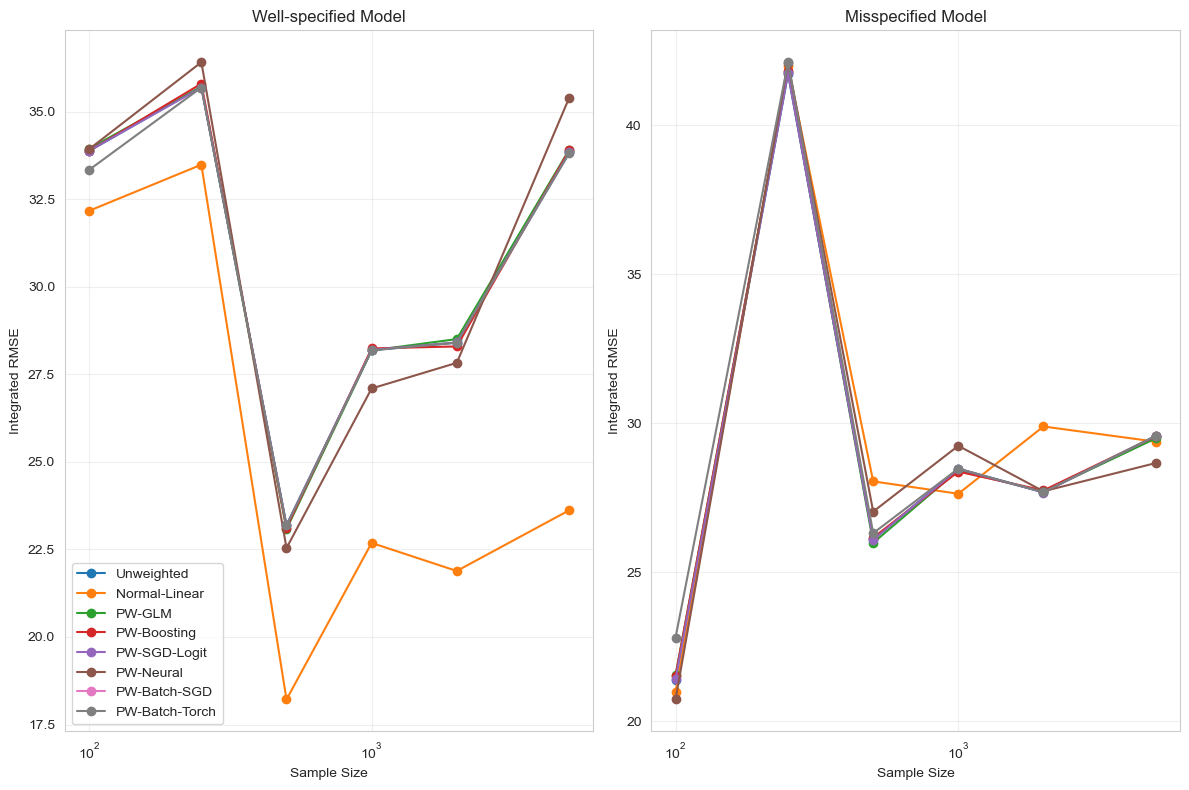

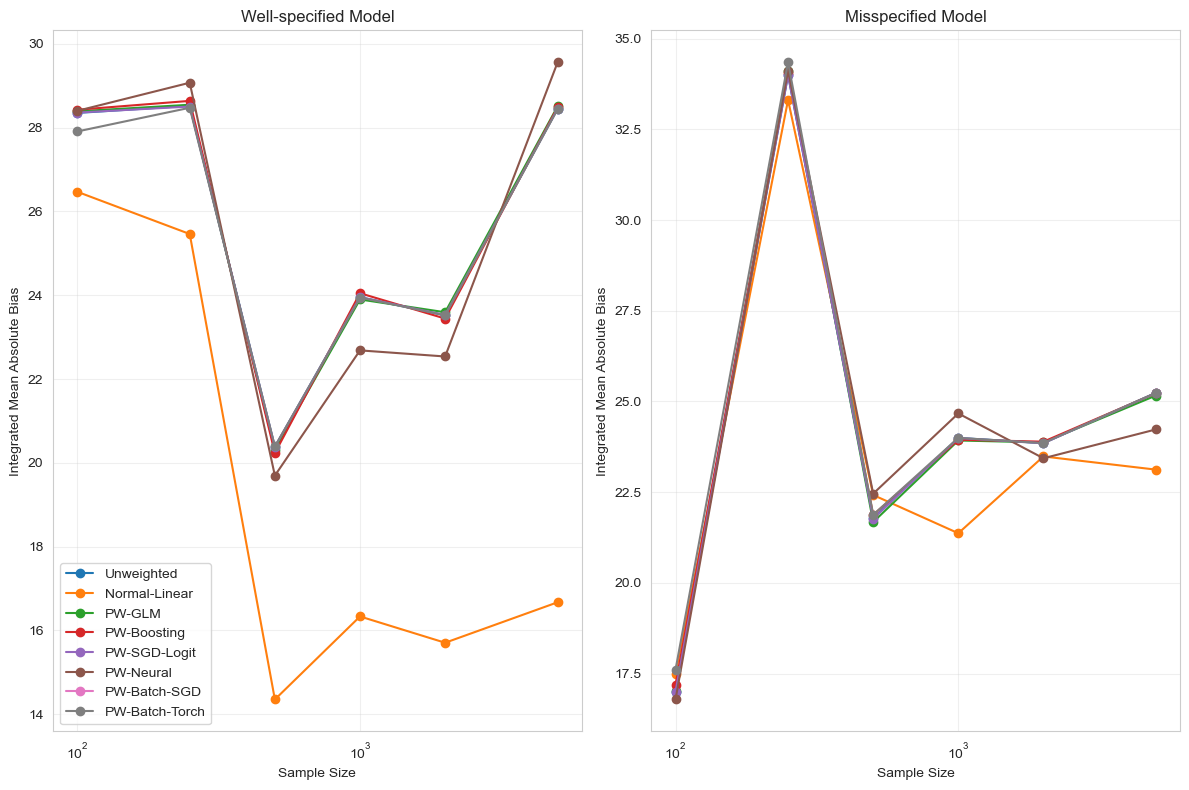

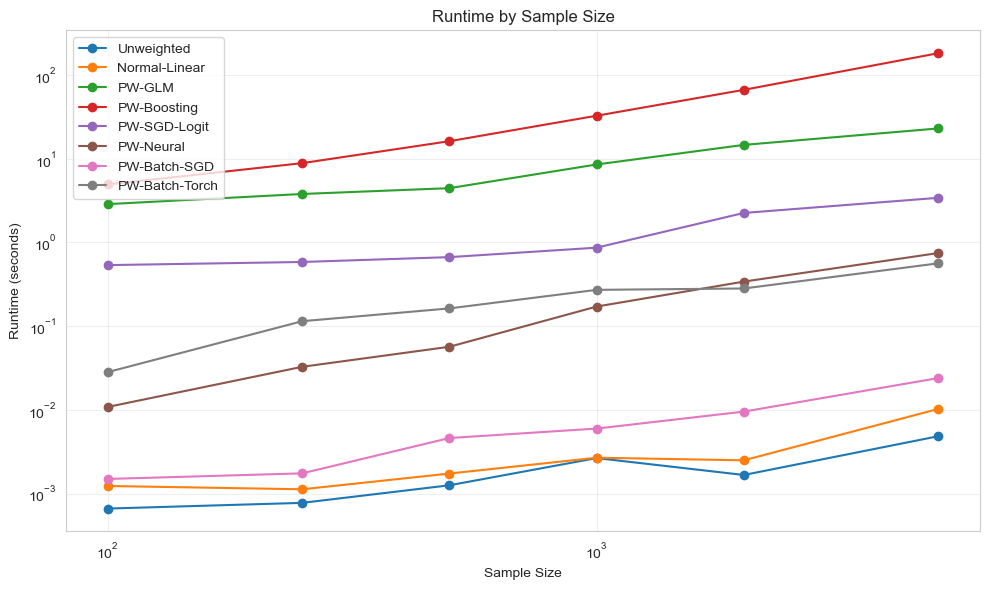

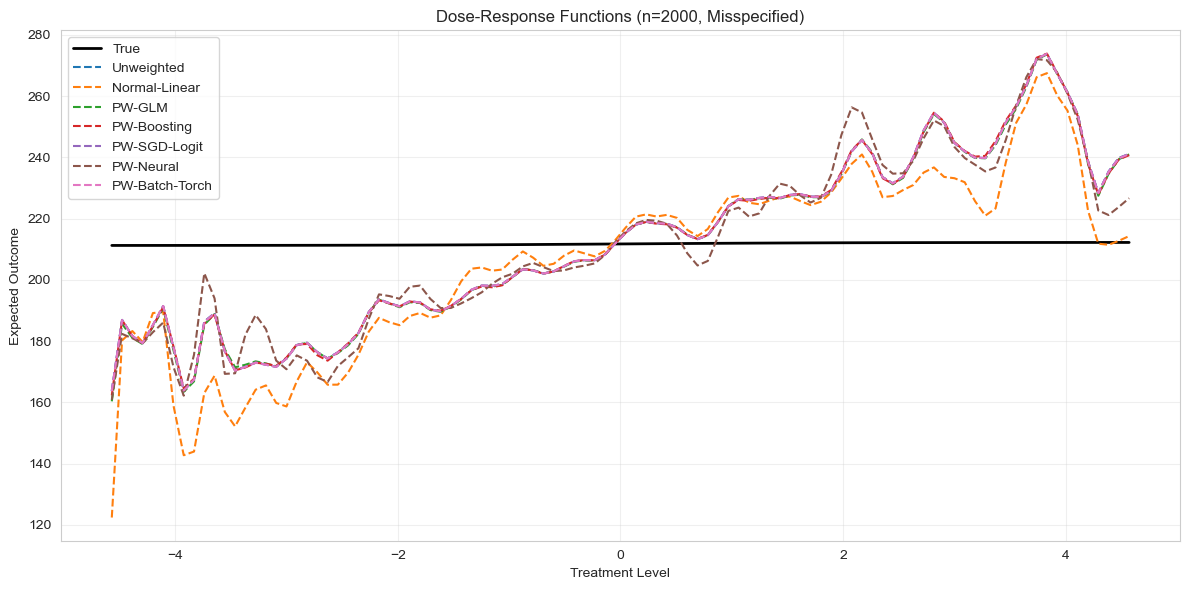

In [5]:
# Example usage
if __name__ == "__main__":
    # Define sample sizes to test
    sample_sizes = [100, 250, 500, 1000, 2000, 5000]
    
    # Define specifications (well-specified vs misspecified)
    specifications = [False, True]
    
    # Run simulation experiment
    all_results = run_simulation_experiment(sample_sizes, specifications, methods, num_iterations=1)
    
    # Analyze results
    metrics_df, summary, complexity = analyze_results(all_results)
    
    # Print complexity results
    print("\nTime Complexity Analysis (slope of time vs. sample size):")
    for method, slope in complexity.items():
        print(f"{method}: O(n^{slope:.2f})")
    
    # Plot results
    plot_results(summary)
    
    # Plot dose-response functions
    plot_dose_response(all_results, n=2000, misspecified=True)